# Analyse de Données de Log de Signaux

Ce notebook Jupyter a pour but de vous guider à travers les différentes étapes de l'analyse de données de signaux. Il utilise le module Python `data_processor.py` pour séparer la logique de préparation des données de l'analyse elle-même.

## Étape 1 : Lecture et préparation des fichiers de log

Nous allons utiliser la fonction `process_logs()` du module `data_processor` pour lire le fichier JSON et ses logs BLF associés. Le DataFrame combiné sera ensuite sauvegardé au format Parquet pour une utilisation ultérieure. Cette approche permet une exécution en mode 'headless' du script si nécessaire.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import os

# Import du module personnalisé
import data_processor

# Définition des chemins de fichiers
# root_path = os.path.join(os.path.dirname(__file__), '..')
root_path = ".."
app_log_dir_path = os.path.join(root_path, 'app_logs')
# json_file_path = os.path.join(root_path, 'app_logs', 'app_log_20250820_144810-example.json')
output_parquet_path = os.path.join(root_path, 'analysis', 'decoded_signals.parquet')

target_value_column = "hardness"

# Traitement des données via le module externe
df_full = data_processor.process_logs(app_log_dir_path, root_path)

if df_full is not None and not df_full.empty:
    # Sauvegarde du DataFrame en fichier Parquet
    df_full.to_parquet(output_parquet_path)
    print(f"Données combinées sauvegardées dans '{output_parquet_path}'.")

    print("\nAperçu des 5 premières lignes du DataFrame final :")
    print(df_full.head())
    print("\nInformations sur le DataFrame final :")
    df_full.info()

    # Visualisation initiale des signaux (exemple sur les colonnes numériques)
    df_full.select_dtypes(include=np.number).plot(figsize=(12, 6), title="Visualisation Initiale des Signaux")
    plt.xlabel("Timestamp")
    plt.ylabel("Valeur du Signal")
    plt.legend()
    plt.show()
else:
    print("Échec du traitement des fichiers. Le reste du notebook ne peut pas s'exécuter.")

Erreur le fichier DBC n'est pas indiqué dans le fichier de log : ..\app_logs\app_log_20250820_143652.json
Erreur lors du chargement de la base de données DBC : [Errno 2] No such file or directory: '..\\db-full.dbc'
Erreur le fichier DBC n'est pas indiqué dans le fichier de log : ..\app_logs\app_log_20250820_145023.json
Erreur le fichier DBC n'est pas indiqué dans le fichier de log : ..\app_logs\app_log_20250822_081310.json
Erreur le fichier DBC n'est pas indiqué dans le fichier de log : ..\app_logs\app_log_20250822_081517.json
Erreur le fichier DBC n'est pas indiqué dans le fichier de log : ..\app_logs\app_log_20250822_081851.json
Erreur le fichier DBC n'est pas indiqué dans le fichier de log : ..\app_logs\app_log_20250822_082038.json
Erreur le fichier DBC n'est pas indiqué dans le fichier de log : ..\app_logs\app_log_20250822_082733.json
Erreur le fichier DBC n'est pas indiqué dans le fichier de log : ..\app_logs\app_log_20250822_133944.json
Erreur le fichier DBC n'est pas indiqué dan

## Étape 2 : Nettoyage et prétraitement des données

Nous allons maintenant utiliser le fichier Parquet généré pour la suite de l'analyse. Cette étape est cruciale pour gérer les valeurs manquantes et aberrantes (outliers), qui peuvent fausser les résultats de l'analyse et des modèles.

In [13]:
# Charger le fichier Parquet pour continuer l'analyse
try:
    df = pd.read_parquet(output_parquet_path)
    print(f"Fichier '{output_parquet_path}' chargé avec succès.")
except FileNotFoundError:
    print("Erreur: Le fichier Parquet n'a pas été trouvé. Veuillez ré-exécuter la première cellule.")
    exit()

# Vérification et gestion des valeurs manquantes
print("\nNombre de valeurs manquantes par colonne :")
print(df.isnull().sum())

# Remplissage des valeurs manquantes avec la moyenne de la colonne
df.fillna(method='ffill', inplace=True)

# Remplissage des valeurs manquantes restantes (au début du DataFrame)
df.fillna(0, inplace=True)

print("\nValeurs manquantes après remplissage :")
print(df.isnull().sum())

# Détection et suppression des outliers par la méthode de l'IQR
Q1 = df.select_dtypes(include=np.number).quantile(0.25)
Q3 = df.select_dtypes(include=np.number).quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrage du DataFrame
df_cleaned = df[~((df.select_dtypes(include=np.number) < lower_bound) | (df.select_dtypes(include=np.number) > upper_bound)).any(axis=1)]

print(f"\nNombre de lignes avant nettoyage des outliers : {len(df)}")
print(f"Nombre de lignes après nettoyage des outliers : {len(df_cleaned)}")

Fichier '..\analysis\decoded_signals.parquet' chargé avec succès.

Nombre de valeurs manquantes par colonne :
signal_PF_BUCKET_TempMems    4026
signal_PF_BUCKET_TempMain    4026
signal_PF_BUCKET_AccX        3899
signal_PF_BUCKET_AccY        3899
signal_PF_BUCKET_AccZ        3899
                             ... 
start_lon                       0
start_speed                     0
session_id                      0
hardness                        0
test_name                       0
Length: 98, dtype: int64

Valeurs manquantes après remplissage :
signal_PF_BUCKET_TempMems    0
signal_PF_BUCKET_TempMain    0
signal_PF_BUCKET_AccX        0
signal_PF_BUCKET_AccY        0
signal_PF_BUCKET_AccZ        0
                            ..
start_lon                    0
start_speed                  0
session_id                   0
hardness                     0
test_name                    0
Length: 98, dtype: int64

Nombre de lignes avant nettoyage des outliers : 4032
Nombre de lignes après nettoyag

C:\Users\g.JANISZEWSKI\AppData\Local\Temp\ipykernel_33252\824365270.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


## Étape 3 : Recherche de corrélation dans les données

Comprendre les relations entre les signaux est un aspect fondamental de la science des données. Nous allons calculer et visualiser une matrice de corrélation pour identifier les signaux qui sont fortement liés à la variable cible ou entre eux. 

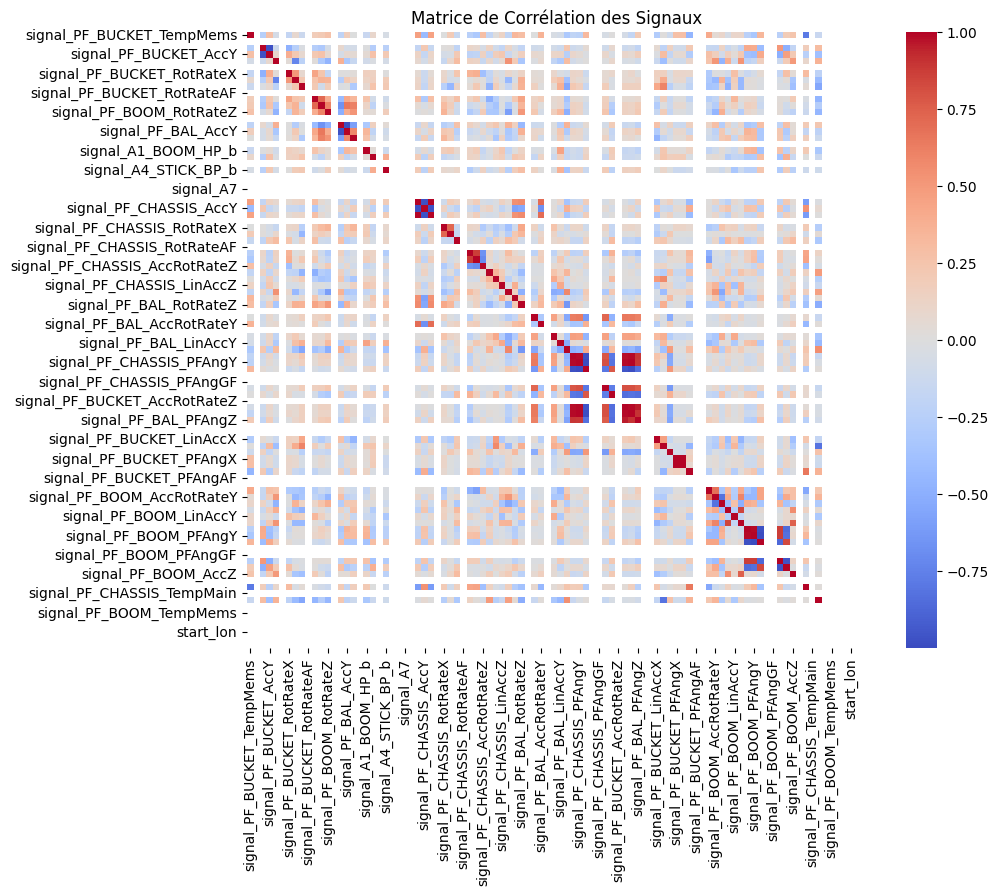

Matrice de corrélation :
                           signal_PF_BUCKET_TempMems  \
signal_PF_BUCKET_TempMems                   1.000000   
signal_PF_BUCKET_TempMain                        NaN   
signal_PF_BUCKET_AccX                      -0.253486   
signal_PF_BUCKET_AccY                       0.280295   
signal_PF_BUCKET_AccZ                      -0.067959   
...                                              ...   
signal_PF_BOOM_TempMain                          NaN   
start_lat                                        NaN   
start_lon                                        NaN   
start_speed                                      NaN   
hardness                                         NaN   

                           signal_PF_BUCKET_TempMain  signal_PF_BUCKET_AccX  \
signal_PF_BUCKET_TempMems                        NaN              -0.253486   
signal_PF_BUCKET_TempMain                        NaN                    NaN   
signal_PF_BUCKET_AccX                            NaN             

In [14]:
# Calcul de la matrice de corrélation
correlation_matrix = df_cleaned.corr(numeric_only=True)

# Affichage de la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de Corrélation des Signaux')
plt.show()

print("Matrice de corrélation :")
print(correlation_matrix)

## Étape 4 : Mise en œuvre de trois algorithmes de machine learning

Nous allons appliquer trois techniques différentes de machine learning pour prédire la valeur cible. Nous utiliserons des modèles de régression pour cet exemple, car la variable cible est une valeur numérique.

1.  **Régression Linéaire** : Un modèle simple et interprétable.
2.  **Random Forest Regressor** : Un modèle d'ensemble puissant, réputé pour sa robustesse.
3.  **Support Vector Regressor (SVR)** : Un modèle efficace pour les données complexes.

In [15]:
# Séparation des données en X (features) et y (cible)
X = df_cleaned.select_dtypes(include=np.number).drop(target_value_column, axis=1)
y = df_cleaned[target_value_column]

# Séparation des données en ensembles d'entraînement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle 1 : Régression Linéaire
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Modèle 2 : Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Modèle 3 : Support Vector Regressor (SVR)
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("Les trois modèles ont été entraînés avec succès.")

Les trois modèles ont été entraînés avec succès.


## Étape 5 : Analyse et comparaison des résultats

Pour évaluer la performance de chaque modèle, nous allons utiliser deux métriques clés : l'**Erreur Quadratique Moyenne (MSE)** et le **coefficient de détermination R²**.

--- Évaluation des performances des modèles ---
Régression Linéaire : MSE = 0.0000, R² = 1.0000
Random Forest : MSE = 0.0000, R² = 1.0000
SVM : MSE = 0.0000, R² = 1.0000


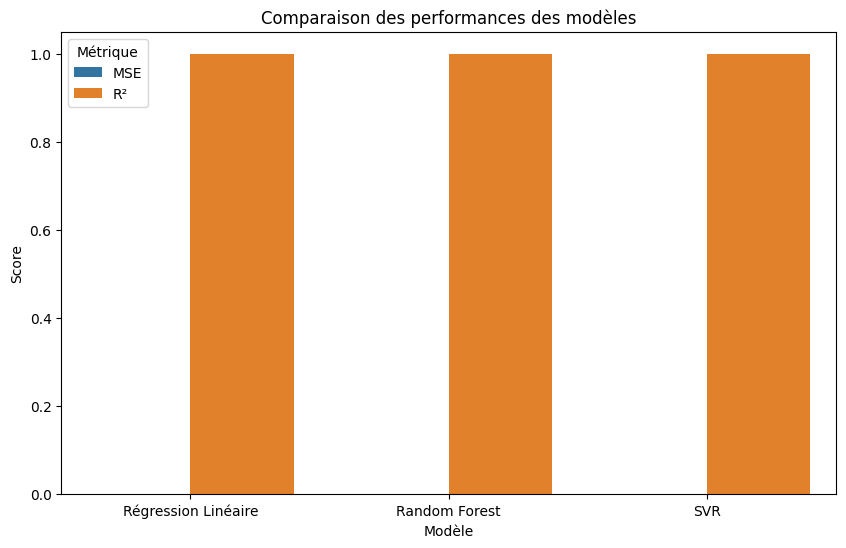

In [16]:
print("--- Évaluation des performances des modèles ---")

# Évaluation de la Régression Linéaire
mse_lr = mean_squared_error(y_test, lr_pred)
r2_lr = r2_score(y_test, lr_pred)
print(f"Régression Linéaire : MSE = {mse_lr:.4f}, R² = {r2_lr:.4f}")

# Évaluation du Random Forest
mse_rf = mean_squared_error(y_test, rf_pred)
r2_rf = r2_score(y_test, rf_pred)
print(f"Random Forest : MSE = {mse_rf:.4f}, R² = {r2_rf:.4f}")

# Évaluation du SVR
mse_svm = mean_squared_error(y_test, svm_pred)
r2_svm = r2_score(y_test, svm_pred)
print(f"SVM : MSE = {mse_svm:.4f}, R² = {r2_svm:.4f}")

# Comparaison visuelle des performances
results_df = pd.DataFrame({
    'Modèle': ['Régression Linéaire', 'Random Forest', 'SVR'],
    'MSE': [mse_lr, mse_rf, mse_svm],
    'R²': [r2_lr, r2_rf, r2_svm]
})

results_df_melted = results_df.melt('Modèle', var_name='Métrique', value_name='Valeur')

plt.figure(figsize=(10, 6))
sns.barplot(x='Modèle', y='Valeur', hue='Métrique', data=results_df_melted)
plt.title('Comparaison des performances des modèles')
plt.ylabel('Score')
plt.show()

## Étape 6 : Visualisation des résultats et explication

Pour une meilleure compréhension, nous allons tracer les valeurs prédites par rapport aux valeurs réelles pour chaque modèle, ce qui nous permet de voir visuellement la précision de chaque algorithme.

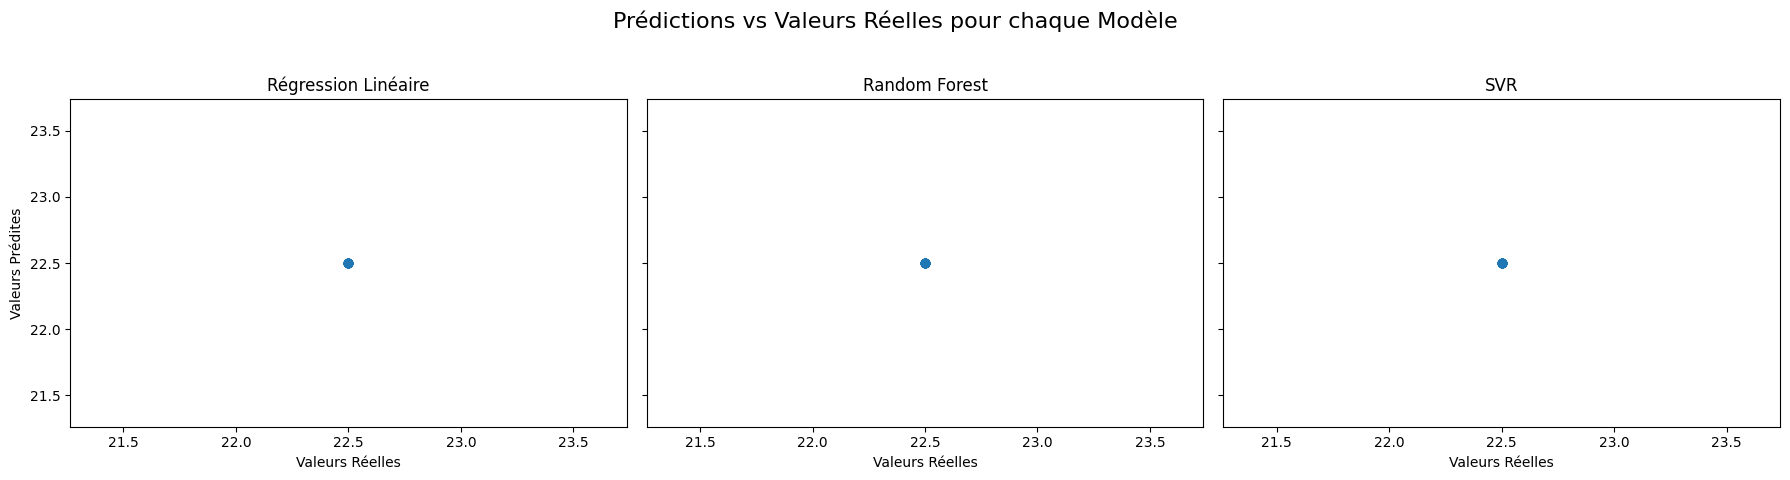

Explication :
Chacun de ces graphiques représente les valeurs prédites par le modèle en fonction des valeurs réelles. Plus les points sont proches de la ligne rouge en pointillés (représentant une prédiction parfaite), plus le modèle est précis. La Régression Linéaire tend à être plus simple et peut moins bien capturer les relations complexes, tandis que des modèles plus avancés comme le Random Forest peuvent fournir des prédictions plus précises.


In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Prédictions vs Valeurs Réelles pour chaque Modèle', fontsize=16)

# Graphique de la Régression Linéaire
axes[0].scatter(y_test, lr_pred, alpha=0.6)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0].set_title('Régression Linéaire')
axes[0].set_xlabel('Valeurs Réelles')
axes[0].set_ylabel('Valeurs Prédites')

# Graphique du Random Forest
axes[1].scatter(y_test, rf_pred, alpha=0.6)
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Valeurs Réelles')

# Graphique du SVR
axes[2].scatter(y_test, svm_pred, alpha=0.6)
axes[2].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[2].set_title('SVR')
axes[2].set_xlabel('Valeurs Réelles')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Explication :")
print("Chacun de ces graphiques représente les valeurs prédites par le modèle en fonction des valeurs réelles. Plus les points sont proches de la ligne rouge en pointillés (représentant une prédiction parfaite), plus le modèle est précis. La Régression Linéaire tend à être plus simple et peut moins bien capturer les relations complexes, tandis que des modèles plus avancés comme le Random Forest peuvent fournir des prédictions plus précises.")